In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

sns.set_style("darkgrid")

In [ ]:
# NREL Dataset https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=nrel-pds-building-stock%2Fend-use-load-profiles-for-us-building-stock%2F2021%2Fcomstock_amy2018_release_1%2Ftimeseries_individual_buildings%2Fby_state%2Fupgrade%3D0%2Fstate%3DUT%2F

In [ ]:
data = pd.read_csv("./Dataset/household_power_consumption.txt", sep=";")

In [ ]:
# convert to datetime
data["datetime"] = data["Date"] + " " + data["Time"]
data["datetime"] = pd.to_datetime(data["datetime"], dayfirst=True)

In [ ]:
#set datetime as index

data.drop(columns=["Date", "Time"], inplace=True)
data.set_index("datetime", inplace=True)


In [ ]:
# replace ? and convert each col to float and fillnas

for col in data.columns:
    data[col].replace("?", np.nan, inplace=True)
    data[col] = data[col].astype(np.float32)

data.ffill( axis=0, inplace=True)

In [ ]:
# concatenate by hour using index

data_resampled = data.resample("H").sum()
data_resampled["hour"] = data_resampled.index.hour
data_resampled.index = data_resampled.index.date


In [ ]:
# plot energy usage

data_resampled.pivot(columns='hour', values="Global_active_power").dropna().T.plot(figsize=(12, 6), alpha=0.02, color="blue", legend=False)

In [ ]:
# only get power and hour data 
data_pivot = data_resampled.pivot(columns="hour", values="Global_active_power").dropna()
train_x = data_pivot.values


In [ ]:
# elbow curve to get estimated profiles 

km_models = [KMeans(n_clusters=k, n_init="auto", random_state=42).fit(train_x) for k in range(2, 10)]
k_inertias = [model.inertia_ for model in km_models]

plt.figure(figsize=(6, 4))
sns.lineplot(x=range(2,10,1), y=k_inertias)
plt.title("Elbow curve")
plt.xlabel("k")
plt.ylabel("intertia")
plt.xticks(range(2, 10, 1));

In [ ]:
# silhoutte diagram to get estimated profiles

k_silhouttes = [silhouette_score(train_x, model.labels_) for model in km_models]

plt.figure(figsize=(6,4))
sns.lineplot(x=range(2,10,1), y=k_silhouttes)
plt.title("Silhoutte scores")
plt.xlabel("k")
plt.ylabel("Score")
plt.xticks(range(2,10,1));


In [ ]:
# use k=2
kmeans = KMeans(n_clusters=2, n_init="auto")
clusters = kmeans.fit_predict(train_x)
clusters_sr = pd.Series(clusters, name="cluster")


In [ ]:
cluster_df = data_pivot.set_index(clusters_sr, append=True)

In [ ]:
color = ["red", "black"]
cluster_labels = cluster_df.index.get_level_values(1).unique()

fig, ax = plt.subplots(figsize=(12, 6))
for cluster, color in zip(cluster_labels, color):

    cluster_df.xs(cluster, level=1).T.plot(alpha=0.02, color=color, legend=False, ax=ax)
    cluster_df.xs(cluster, level=1).T.median(axis=1).plot(color=color, ls="--", legend=False, ax=ax)

plt.ylabel("Power, kW")
plt.title("Power usage profiles")
plt.xticks(range(0, 24, 1));
    




In [ ]:
### COMMERCIAL BUILDING ANALYSIS
# NREL Dataset https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=nrel-pds-building-stock%2Fend-use-load-profiles-for-us-building-stock%2F2021%2Fcomstock_amy2018_release_1%2Ftimeseries_individual_buildings%2Fby_state%2Fupgrade%3D0%2Fstate%3DUT%2F

In [ ]:
filepath = Path("./Dataset/")
filelist = list(filepath.glob("*.parquet"))
print(f"Buildings in dataset: {len(filelist)}")

In [ ]:
electric_cols = ['timestamp','out.electricity.cooling.energy_consumption',
 'out.electricity.exterior_lighting.energy_consumption',
 'out.electricity.fans.energy_consumption',
 'out.electricity.heat_recovery.energy_consumption',
 'out.electricity.heat_rejection.energy_consumption',
 'out.electricity.heating.energy_consumption',
 'out.electricity.interior_equipment.energy_consumption',
 'out.electricity.interior_lighting.energy_consumption',
 'out.electricity.pumps.energy_consumption',
 'out.electricity.refrigeration.energy_consumption',
 'out.electricity.water_systems.energy_consumption',
 'out.electricity.total.energy_consumption',
 'out.electricity.cooling.energy_consumption_intensity',
 'out.electricity.exterior_lighting.energy_consumption_intensity',
 'out.electricity.fans.energy_consumption_intensity',
 'out.electricity.heat_recovery.energy_consumption_intensity',
 'out.electricity.heat_rejection.energy_consumption_intensity',
 'out.electricity.heating.energy_consumption_intensity',
 'out.electricity.interior_equipment.energy_consumption_intensity',
 'out.electricity.interior_lighting.energy_consumption_intensity',
 'out.electricity.pumps.energy_consumption_intensity',
 'out.electricity.refrigeration.energy_consumption_intensity',
 'out.electricity.water_systems.energy_consumption_intensity']

In [ ]:
# Get each file and concat with only electric columns

data_df = pd.DataFrame()
for file in filelist:
    df = pd.read_parquet(file)
    electric_df = df[electric_cols]
    data_df = pd.concat([data_df, electric_df])
    data_df.fillna(0, inplace=True)

data_df.shape


In [ ]:
# aggregate and preprocess data 

data_df = data_df.groupby("timestamp").mean()
data_resampled = data_df.resample('H').sum()
data_resampled["total_usage"] = data_resampled.sum(axis=1)

In [ ]:
data_resampled["hour"] = data_resampled.index.hour
data_resampled["date"] = data_resampled.index.date
data_resampled.set_index("date", inplace=True)

In [ ]:
# only keep power data for now

data_power_only = data_resampled[["total_usage", "hour"]]
data_power_only = data_power_only.pivot(columns="hour", values="total_usage").dropna()
data_power_only.T.plot(figsize=(12, 4), xticks=range(0,25,1), legend=False, color="blue", alpha=0.02)

In [ ]:
# clustering the data 

train_x = data_power_only.values
kmeans_models = [KMeans(n_clusters=k, n_init="auto").fit(train_x) for k in range(2,8)]

In [ ]:
# get the elbow curve

inertias = [model.inertia_ for model in kmeans_models]

plt.figure(figsize=(6, 4))
sns.lineplot(x=range(2,8,1), y=inertias)
plt.xticks(range(2,8,1))
plt.xlabel("k")
plt.ylabel("inertia")
plt.title("Elbow curve");

In [ ]:
# get the silhoutte score
sil_score = [silhouette_score(train_x, model.labels_) for model in kmeans_models]

plt.figure(figsize=(6, 4))
sns.lineplot(x=range(2,8,1), y=sil_score)
plt.xticks(range(2,8,1))
plt.xlabel("k")
plt.ylabel("Score")
plt.title("Silhoutte Score");

In [ ]:
# Use k=3

kmeans = KMeans(n_clusters=3, n_init="auto")
y_pred = kmeans.fit_predict(train_x)
y_series = pd.Series(y_pred, name="cluster")

In [ ]:
clustered_df = data_power_only.set_index(y_series, append=True)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
clusters = clustered_df.index.get_level_values(1).unique()
colors = ["red", "blue", "green"]
for cluster, color in zip(clusters, colors):
    clustered_df.xs(cluster, level=1).T.plot(color=color, ax=ax, alpha=0.02,legend=False)
    clustered_df.xs(cluster, level=1).T.median(axis=1).plot(color=color, ax=ax,legend=False, ls="--")
    
plt.ylabel("Power, kW")
plt.title("Power usage profiles")
plt.xticks(range(0, 24, 1));

In [ ]:
# utilizing DBSCAN for clustering

minimum_samples = 30
knn = NearestNeighbors(n_neighbors=minimum_samples)
knn.fit(train_x)
distances, indices = knn.kneighbors(train_x)


In [ ]:
distances_sorted = np.sort(distances, axis=0)
distances_sorted = distances_sorted[:,1]
sns.lineplot(distances_sorted)
plt.ylabel("distance")
plt.title("k-distance chart");

In [ ]:
eps = 24
dbscan = DBSCAN(eps=eps, min_samples = minimum_samples)
y_pred = dbscan.fit_predict(train_x)

In [ ]:
y_sr = pd.Series(y_pred, name="cluster")
data_power_clustered = data_power_only.set_index(y_sr, append=True)

In [ ]:
clusters = y_sr.unique()
colors = ["red", "blue", "green", "black", "magenta"]
cluster_colors = zip(clusters, colors[:len(clusters)])


In [ ]:
for cluster, color in cluster_colors:
    number_days= data_power_clustered.xs(cluster, level=1).shape[0]
    print(f"Cluster {cluster} has {number_days} days, color used: {color}")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
for cluster, color in zip(clusters, colors[:len(clusters)]):
    data_power_clustered.xs(cluster, level=1).T.plot(legend=False, alpha=0.02, ax=ax, color=color)
    data_power_clustered.xs(cluster, level=1).T.median(axis=1).plot(legend=False, color=color, ax=ax, ls="--")
plt.ylabel("Power, kW")
plt.title("Power usage profiles")
plt.xticks(range(0, 24, 1));

In [18]:
### DBSCAN anomaly detection

anomaly_df = pd.read_csv("./Dataset/sensor.csv")
anomaly_df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [19]:
anomaly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [20]:
# nulls

(anomaly_df.isnull().sum() /anomaly_df.shape[0])*100

Unnamed: 0          0.000000
timestamp           0.000000
sensor_00           4.633261
sensor_01           0.167484
sensor_02           0.008624
sensor_03           0.008624
sensor_04           0.008624
sensor_05           0.008624
sensor_06           2.177741
sensor_07           2.474129
sensor_08           2.317992
sensor_09           2.085603
sensor_10           0.008624
sensor_11           0.008624
sensor_12           0.008624
sensor_13           0.008624
sensor_14           0.009532
sensor_15         100.000000
sensor_16           0.014070
sensor_17           0.020879
sensor_18           0.020879
sensor_19           0.007262
sensor_20           0.007262
sensor_21           0.007262
sensor_22           0.018609
sensor_23           0.007262
sensor_24           0.007262
sensor_25           0.016340
sensor_26           0.009078
sensor_27           0.007262
sensor_28           0.007262
sensor_29           0.032680
sensor_30           0.118464
sensor_31           0.007262
sensor_32     

In [21]:
# clean_up

anomaly_df.drop(columns=["sensor_15", "Unnamed: 0"], inplace=True)
anomaly_df["timestamp"] = pd.to_datetime(anomaly_df["timestamp"])
anomaly_df.set_index("timestamp", drop=True, inplace=True)

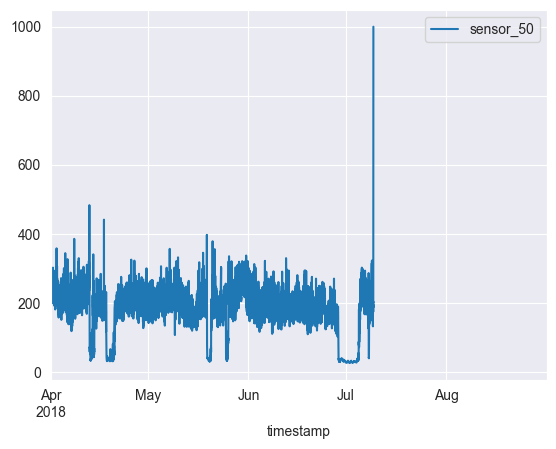

In [34]:
# sensor 50 did not work after July,so removing it
anomaly_df[["sensor_50"]].plot()
anomaly_df.drop(columns=["sensor_50"], inplace=True)

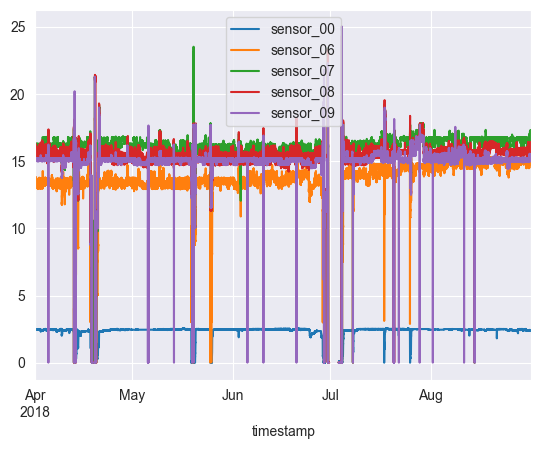

In [36]:
# the nans appear in between anomalies when there is a drop in the values, so imputing them with 0

anomaly_df[["sensor_00", "sensor_06", "sensor_07", "sensor_08", "sensor_09"]].plot()
anomaly_df.fillna(0, inplace=True)

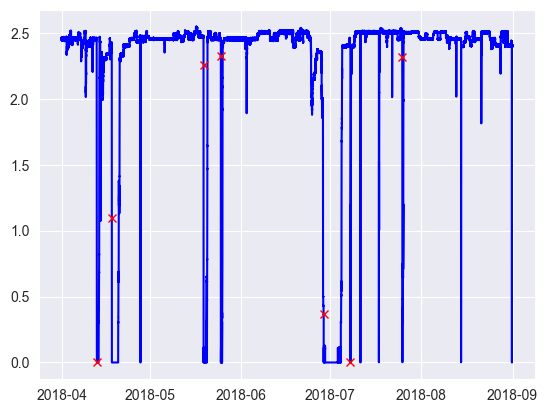

In [43]:
status = anomaly_df[anomaly_df["machine_status"] == "BROKEN"]
fig, ax = plt.subplots(1, 1)
plt.plot(anomaly_df["sensor_00"], color="blue")
plt.plot(status["sensor_00"], marker="x", color="red", linestyle='none')


c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nitis\nitish\machine_learning\energy_consumption_clustering\lib\site-packages\sea

Text(0.5, 1.0, 'series stationarity')

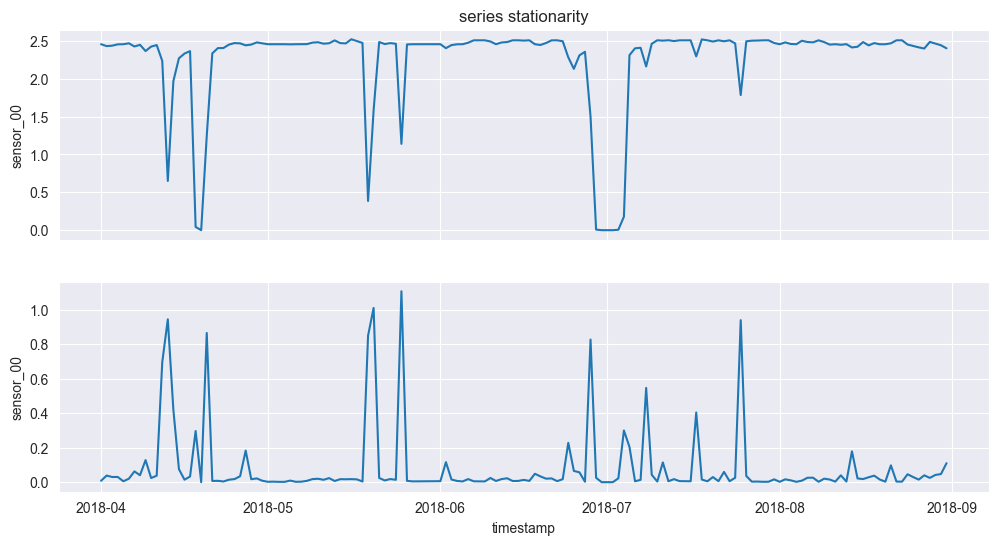

In [61]:
# check for stationarity
sensor_cols = anomaly_df.select_dtypes(include=["float64"]).columns.tolist()
daily_mean_df = anomaly_df[sensor_cols].resample(rule="D").mean()
daily_std_df = anomaly_df[sensor_cols].resample(rule="D").std()

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
sns.lineplot(x = daily_mean_df.index, y=daily_mean_df["sensor_00"], ax=ax[0])
sns.lineplot(x = daily_std_df.index, y=daily_std_df["sensor_00"], ax=ax[1])
ax[0].set_title("series stationarity")

